In [1]:
from keras.models import Sequential, load_model
from keras.layers import *
from keras import optimizers
from keras import utils
from keras.callbacks import TensorBoard, ModelCheckpoint

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

import tensorflow as tf

# Importing matplotlib to plot images.
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Importing SK-learn to calculate precision and recall
import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneGroupOut
from sklearn.utils import shuffle 

# Used for graph export
from tensorflow.python.framework import graph_util
from tensorflow.python.framework import graph_io
from keras import backend as K

import pickle as pkl
import h5py

from pathlib import Path
import os.path
import sys
import datetime
import time



Using TensorFlow backend.


In [2]:
import telegram
from keras.callbacks import Callback
from callbacks import TelegramCallback
from callbacks.TelegramData import TelegramData


# create callback
config = {
    'token': TelegramData.Token,   # paste your bot token
    'telegram_id': TelegramData.ID,                                   # paste your telegram_id
}

tg_callback = TelegramCallback(config)

In [3]:
class LoggingTensorBoard(TensorBoard):    

    def __init__(self, log_dir, settings_str_to_log, **kwargs):
        super(LoggingTensorBoard, self).__init__(log_dir, **kwargs)

        self.settings_str = settings_str_to_log

    def on_train_begin(self, logs=None):
        TensorBoard.on_train_begin(self, logs=logs)

        tensor =  tf.convert_to_tensor(self.settings_str)
        summary = tf.summary.text ("Run_Settings", tensor)

        with  tf.Session() as sess:
            s = sess.run(summary)
            self.writer.add_summary(s)

In [4]:
train_ids = [3, 4, 5, 6, 7, 8]
test_ids = [1, 2]

In [5]:
# the data, split between train and test sets
dfAll = pd.read_pickle("PklData/df_blobs.pkl")
#df_train = dfAll[(dfAll.userID != 1) | (dfAll.userID != 2)]
#df_test = dfAll[(dfAll.userID == 1) | (dfAll.userID == 2)]
df_train = dfAll[dfAll.userID.isin(train_ids)]
df_test = dfAll[dfAll.userID.isin(test_ids)]

df_test = df_test.reset_index()
df_train = df_train.reset_index()
#Create InputMethod Column and fill it with Knuckel / Finger
def f(row):
    if row['TaskID'] < 17:
        #val = "Knuckle"
        val = 0
    elif row['TaskID'] >= 17:
        #val = "Finger"
        val = 1
    return val
df_train['InputMethod'] = df_train.apply(f, axis=1)
df_test['InputMethod'] = df_test.apply(f, axis=1)
df_train2 = df_train[['Blobs', 'InputMethod']].copy()
df_test2 = df_test[['Blobs', 'InputMethod']].copy()

In [6]:
x_train = np.vstack(df_train2.Blobs)
x_test = np.vstack(df_test2.Blobs)
y_train = df_train2.InputMethod.values
y_test = df_test2.InputMethod.values

x_train = x_train.reshape(-1, 27, 15, 1)
x_test = x_test.reshape(-1, 27, 15, 1)

In [7]:
# convert class vectors to binary class matrices (one-hot notation)
num_classes = 2
y_train_one_hot = utils.to_categorical(df_train2.InputMethod, num_classes)
y_test_one_hot = utils.to_categorical(df_test2.InputMethod, num_classes)

Text(0.5, 1.0, 'Label for image 1 is: 1')

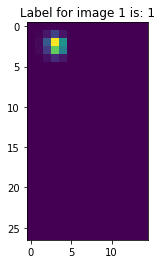

In [8]:
i = 1
plt.imshow(x_train[i].reshape(27, 15)) #np.sqrt(784) = 28
plt.title("Label for image %i is: %s" % (i, y_train[i]))

In [9]:
# If GPU is not available: 
# GPU_USE = '/cpu:0'
# config = tf.ConfigProto(device_count = {"GPU": 0})


# If GPU is available: 
config = tf.ConfigProto()
config.log_device_placement = True
config.allow_soft_placement = True
config.gpu_options.allocator_type = 'BFC'

# Limit the maximum memory used
#config.gpu_options.per_process_gpu_memory_fraction = 0.1

# set session config
tf.keras.backend.set_session(tf.Session(config=config))

In [ ]:

tf.get_default_graph()
########## HYPER PARAMETERS
batch_size = 200
epochs = 550
optimizer = optimizers.Adam()
#optimizer = tf.keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.1)
#init=tf.global_variables_initializer()

########## HYPER PARAMETERS
########## MODEL ARCHITECTURE
model = Sequential()


model.add(Conv2D(84, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(27,15,1)))
model.add(Conv2D(84, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2), strides=None, padding='valid', data_format='channels_last'))
model.add(Dropout(0.10))
model.add(Conv2D(42, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(Conv2D(42, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2), strides=None, padding='valid', data_format='channels_last'))
model.add(Dropout(0.08))
model.add(Flatten())
model.add(Dense(400, activation=('relu'), use_bias=True))
model.add(Dense(100, activation=('relu'), use_bias=True))
model.add(Dense(num_classes, activation='softmax'))
########## MODEL ARCHITECTURE
####TENSORBOARD
config = ""
for layer in model.layers:
    config += str(layer.output).split('\"')[1].split("/")[0] + str(layer.output_shape) + "\n\n"
#### END TENSORBOARD
config += "batchsize: " + str(batch_size) + "\n\n" + "epochs: " + str(epochs) + "\n\n"

# Print summary
model.summary()
readable_timestamp = datetime.datetime.fromtimestamp(time.time()).strftime('%Y%m%d_%H%M%S')
tensorflowfolder = "/srv/share/tensorboardfiles/KnuckleFinger_Jan_" + readable_timestamp

logger = LoggingTensorBoard(settings_str_to_log = config, log_dir=tensorflowfolder, histogram_freq=0, write_graph=True, write_images=True, update_freq = 'epoch')
storer = ModelCheckpoint("./ModelSnapshots/KnuckleFinger_Jan_" + readable_timestamp + ".h5", monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)
# compile model for training
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

history = model.fit(x_train, y_train_one_hot,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test_one_hot),
                    callbacks=[logger, storer, tg_callback])
                    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 27, 15, 84)        840       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 15, 84)        63588     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 7, 84)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 7, 84)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 7, 42)         31794     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 7, 42)         15918     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 3, 42)          0         
__________

In [ ]:
# use model for inference to get test accuracy
y_test_pred = model.predict(x_test)
y_test_pred = np.argmax(y_test_pred, axis=1)

print ('\n Summary of the precision, recall, F1 score for each class:')
print (sklearn.metrics.classification_report(y_test, y_test_pred))

print ('\n Confusion matrix: ')
print (sklearn.metrics.confusion_matrix(y_test, y_test_pred))

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['val_acc'], label="Test Accuracy")
plt.plot(history.history['acc'], label="Training Accuracy")
plt.legend()

In [ ]:
# save model
model.save("2312.h5")